# Late-Classifier + KDE.

In this notebook, we explore the use of the late-classifier along with KDE for the anomaly detection problem. 
For this purpose, we will use the following procedure:
1. A Hierarchical Random Forest classifier will be trained using the training data from the ALeRCE challenge. For the training process, we follow the same procedure and hyperparameters defined in the late-classifier paper.
2. To prevent the KDE to be overfitted over the training data used for training the late-classifier, we use the inliers public test set to train a KDE.
3. We compute the log-likelihood of the private test data over the trained KDE.

Results are reported assuming inlier/outlier classes and also for each outlier class individually.


In [1]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools 

Using TensorFlow backend.


In [2]:
train = pd.read_pickle('train_data.pkl')
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(-999)
train.head()

,challenge_oid,challenge_oid,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,...,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,classALeRCE,hierClass,outClass,outType
0,ZTF18abnosak,458882,-999.000000,0.523886,-999.000000,0.645409,-999.0,1.0,-999.000000,0.444444,...,0.408,0.963,10.001844,9.038844,-999.000000,-999.000000,LPV,Stochastic,Inlier,Inlier
1,ZTF18aaynold,595999,0.242827,0.201823,0.999914,0.999834,5.0,3.0,0.376471,0.279412,...,-0.164,0.650,10.056674,9.406674,13.406566,12.756566,LPV,Stochastic,Inlier,Inlier
2,ZTF19aaejuhu,263928,0.612022,0.469806,1.000000,1.000000,1.0,1.0,0.466667,0.511628,...,-0.312,2.405,4.742247,2.337247,5.748985,3.343985,RRL,Periodic,Inlier,Inlier
3,ZTF18aawerxg,150227,0.106494,0.273638,1.000000,1.000000,6.0,3.0,0.333333,0.105263,...,1.150,2.367,7.511101,5.144101,7.465765,5.098765,QSO,Stochastic,Inlier,Inlier
4,ZTF18abcoxiw,235679,0.419795,0.313525,1.000000,1.000000,1.0,1.0,0.446809,0.478261,...,-0.240,3.560,4.380863,0.820863,4.632955,1.072955,RRL,Periodic,Inlier,Inlier


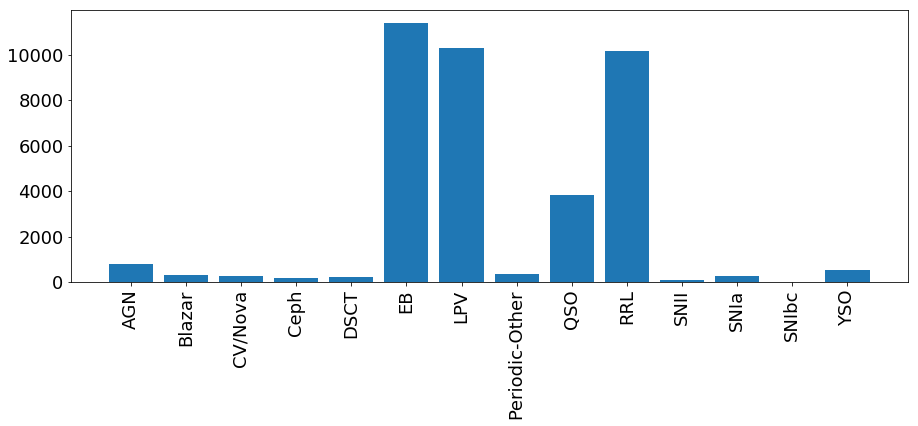

In [3]:
classes, counts = np.unique(train.classALeRCE, return_counts=True)
fig = plt.figure(figsize=(15, 5))
plt.bar(classes, counts)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('ALeRCE_classes')
plt.show()

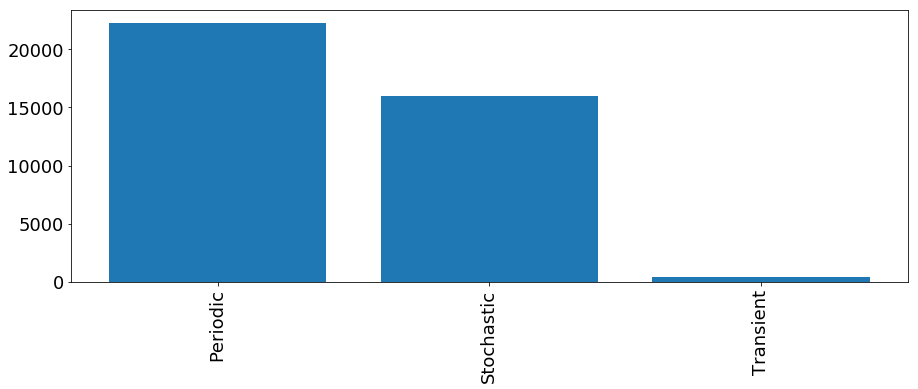

In [4]:
classes, counts = np.unique(train.hierClass, return_counts=True)
fig = plt.figure(figsize=(15, 5))
plt.bar(classes, counts)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('ALeRCE_classes')
plt.show()

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cf_mtx.png', bbox_inches='tight')
    #plt.close()
    
def plot_feature_importances(model, feature_names):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:20]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);

In [6]:
x = train.drop(['hierClass', 'classALeRCE', 'challenge_oid', 'outClass', 'outType'], axis=1)
y = train[['hierClass', 'classALeRCE', 'outClass', 'outType']]
x_train, y_train = x, y 

y_train_hier = y_train.hierClass

x_train_per = x_train[y_train.hierClass == 'Periodic']
y_train_per = y_train[y_train.hierClass == 'Periodic'].classALeRCE

x_train_st = x_train[y_train.hierClass == 'Stochastic']
y_train_st = y_train[y_train.hierClass == 'Stochastic'].classALeRCE

x_train_tr = x_train[y_train.hierClass == 'Transient']
y_train_tr = y_train[y_train.hierClass == 'Transient'].classALeRCE

In [7]:
hier_clf = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


hier_clf.fit(x_train, y_train_hier)

BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced_subsample',
                               criterion='entropy', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               max_samples=None, min_impurity_decrease=0.0,
                               min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=500,
                               n_jobs=-1, oob_score=False, random_state=None,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


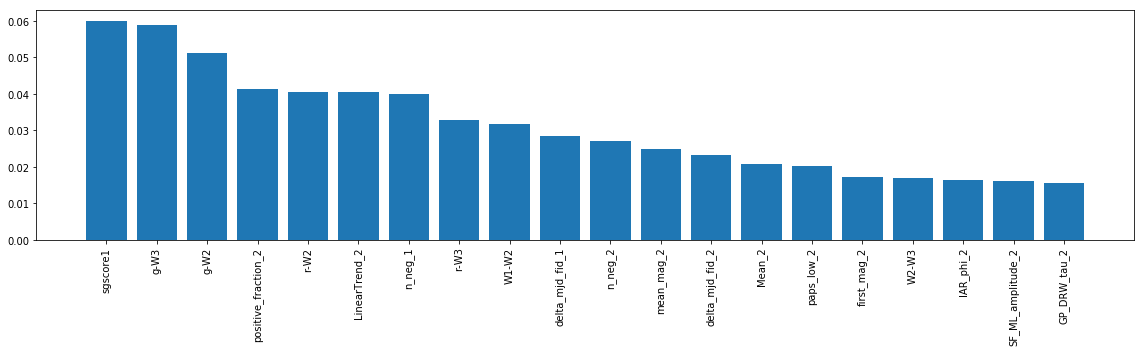

In [8]:
plot_feature_importances(hier_clf, list(x_train))

In [9]:
clf_periodic = RandomForestClassifier(
               n_estimators=500,
               max_features='auto',
               max_depth=None,
               n_jobs=-1,
               class_weight='balanced_subsample',
               #bootstrap=False,
               criterion='entropy',
               min_samples_split=2,
               min_samples_leaf=1)
clf_periodic.fit(x_train_per, y_train_per)


clf_transcient = RandomForestClassifier(
               n_estimators=500,
               max_features='auto',
               max_depth=None,
               n_jobs=-1,
               class_weight='balanced_subsample',
               #bootstrap=False,
               criterion='entropy',
               min_samples_split=2,
               min_samples_leaf=1)
clf_transcient.fit(x_train_tr, y_train_tr)


clf_stochastic = RandomForestClassifier(
               n_estimators=500,
               max_features='auto',
               max_depth=None,
               n_jobs=-1,
               class_weight='balanced_subsample',
               #bootstrap=False,
               criterion='entropy',
               min_samples_split=2,
               min_samples_leaf=1)
clf_stochastic.fit(x_train_st, y_train_st)

BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced_subsample',
                               criterion='entropy', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               max_samples=None, min_impurity_decrease=0.0,
                               min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=500,
                               n_jobs=-1, oob_score=False, random_state=None,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [10]:
train_hier_proba = hier_clf.predict_proba(x_train)
train_per_proba = clf_periodic.predict_proba(x_train)
train_tr_proba = clf_transcient.predict_proba(x_train)
train_st_proba = clf_stochastic.predict_proba(x_train)

prob_per_mtx_train = np.repeat(train_hier_proba[:,0], train_per_proba.shape[1]).reshape(train_hier_proba.shape[0], train_per_proba.shape[1])
y_prob_per_train = train_per_proba * prob_per_mtx_train

prob_st_mtx_train = np.repeat(train_hier_proba[:,1], train_st_proba.shape[1]).reshape(train_hier_proba.shape[0], train_st_proba.shape[1])
y_prob_st_train = train_st_proba * prob_st_mtx_train    

prob_tr_mtx_train = np.repeat(train_hier_proba[:,2], train_tr_proba.shape[1]).reshape(train_hier_proba.shape[0], train_tr_proba.shape[1])
y_prob_tr_train = train_tr_proba * prob_tr_mtx_train      

y_probs_train = np.concatenate((y_prob_per_train, y_prob_st_train, y_prob_tr_train), axis=1)

In [11]:
periodic_names, stochastic_names, transient_names = clf_periodic.classes_, clf_stochastic.classes_, clf_transcient.classes_

classes = np.concatenate((periodic_names, stochastic_names, transient_names))
class_dict = {}

for i, class_name in enumerate(classes):
    class_dict[i] = class_name

In [12]:
y_class_pred_train = np.argmax(y_probs_train, axis=1)
y_name_pred_train = np.array([class_dict[i] for i in y_class_pred_train])
y_name_pred_train.shape

(38685,)

Accuracy: 0.8297272844771876
Balanced accuracy: 0.8690207517805496
Normalized confusion matrix


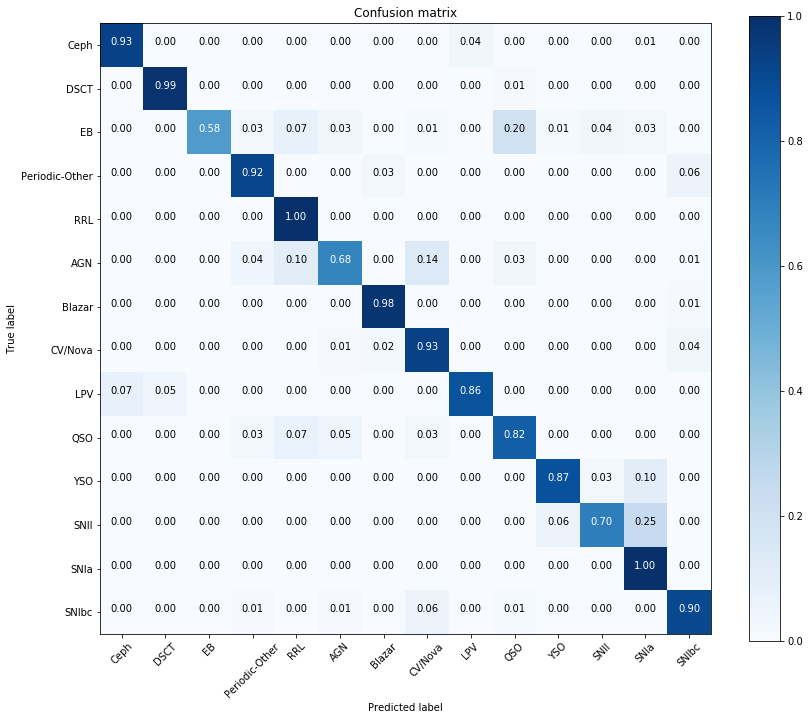

In [13]:
print("Accuracy:", accuracy_score(y_train.classALeRCE, y_name_pred_train))
print("Balanced accuracy:", balanced_accuracy_score(y_train.classALeRCE, y_name_pred_train))
cm_matrix = confusion_matrix(y_train.classALeRCE, y_name_pred_train)
plot_confusion_matrix(cm_matrix, classes)

# Public Test

In [14]:
public_test = pd.read_pickle('public_test_data.pkl')
public_test = public_test.replace([np.inf, -np.inf], np.nan)
public_test = public_test.fillna(-999)
public_test = public_test[public_test.classALeRCE != 'Outlier']
public_test.head()

,challenge_oid,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,...,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,classALeRCE,hierClass,outClass,outType
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aaxljdd,107917,0.445671,0.311820,0.855957,0.833713,1.0,1.0,0.500000,0.285714,0.0,...,0.040,1.367,2.990449,1.623449,3.339882,1.972882,RRL,Periodic,Inlier,Inlier
ZTF18abeuosb,335673,-999.000000,0.141186,-999.000000,0.393831,-999.0,1.0,-999.000000,0.250000,-999.0,...,-0.162,0.602,8.408226,7.806226,-999.000000,-999.000000,LPV,Stochastic,Inlier,Inlier
ZTF18abdiiev,514282,0.623108,0.313181,1.000000,0.999962,9.0,5.0,0.439560,0.245902,0.0,...,0.136,1.766,8.462407,6.696407,11.843507,10.077507,LPV,Stochastic,Inlier,Inlier
ZTF18aaqpybd,295147,0.096622,0.099643,0.592401,0.999986,5.0,5.0,0.350000,0.311111,0.0,...,1.408,2.869,7.725034,4.856034,8.002895,5.133895,QSO,Stochastic,Inlier,Inlier
ZTF18abaqxeq,408737,0.702779,1.183788,0.487914,0.997776,2.0,5.0,0.358974,0.287879,0.0,...,0.468,1.323,12.642286,11.319286,15.827053,14.504053,LPV,Stochastic,Inlier,Inlier


In [15]:
x_test = public_test.drop(['hierClass', 'classALeRCE', 'challenge_oid', 'outClass', 'outType'], axis=1)
y_test = public_test[['hierClass', 'classALeRCE', 'outClass', 'outType']]

In [16]:
test_hier_proba = hier_clf.predict_proba(x_test)
test_per_proba = clf_periodic.predict_proba(x_test)
test_tr_proba = clf_transcient.predict_proba(x_test)
test_st_proba = clf_stochastic.predict_proba(x_test)

Accuracy: 0.9834340959330972
Balanced accuracy: 0.9820504935561765
Normalized confusion matrix


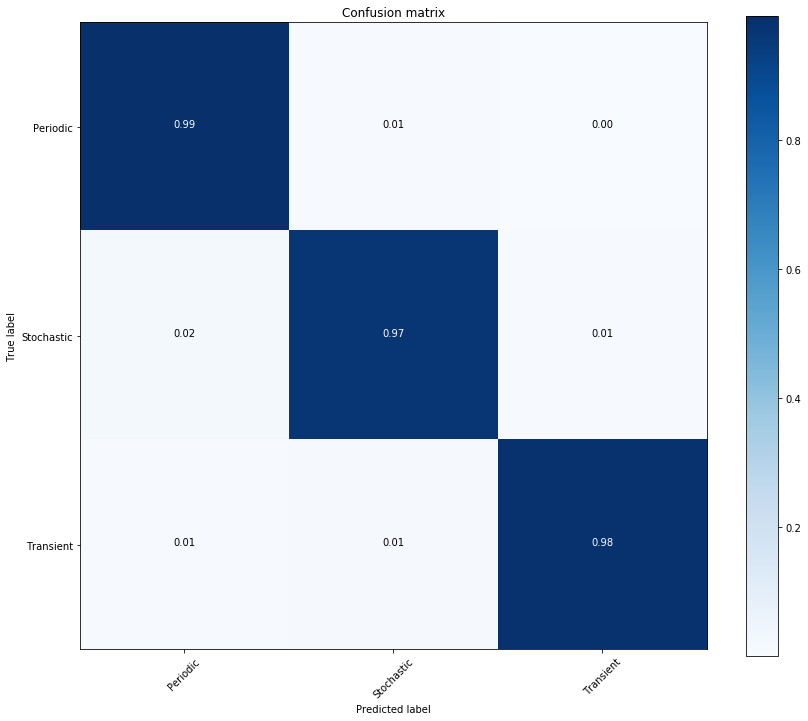

In [17]:
test_hier_pred = hier_clf.predict(x_test)
print("Accuracy:", accuracy_score(y_test.hierClass, test_hier_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test.hierClass, test_hier_pred))
cm_matrix = confusion_matrix(y_test.hierClass, test_hier_pred)
plot_confusion_matrix(cm_matrix, hier_clf.classes_)

In [18]:
prob_per_mtx = np.repeat(test_hier_proba[:,0], test_per_proba.shape[1]).reshape(test_hier_proba.shape[0], test_per_proba.shape[1])
y_prob_per = test_per_proba * prob_per_mtx

prob_st_mtx = np.repeat(test_hier_proba[:,1], test_st_proba.shape[1]).reshape(test_hier_proba.shape[0], test_st_proba.shape[1])
y_prob_st = test_st_proba * prob_st_mtx

prob_tr_mtx = np.repeat(test_hier_proba[:,2], test_tr_proba.shape[1]).reshape(test_hier_proba.shape[0], test_tr_proba.shape[1])
y_prob_tr = test_tr_proba * prob_tr_mtx

y_probs = np.concatenate((y_prob_per, y_prob_st, y_prob_tr), axis=1)


In [19]:
y_class_pred = np.argmax(y_probs, axis=1)
y_name_pred = np.array([class_dict[i] for i in y_class_pred])
y_name_pred.shape

(37547,)

In [20]:
y_class_pred = np.argmax(y_probs, axis=1)
y_name_pred = np.array([class_dict[i] for i in y_class_pred])


Accuracy: 0.8045649452685967
Balanced accuracy: 0.6998019495402866
Normalized confusion matrix


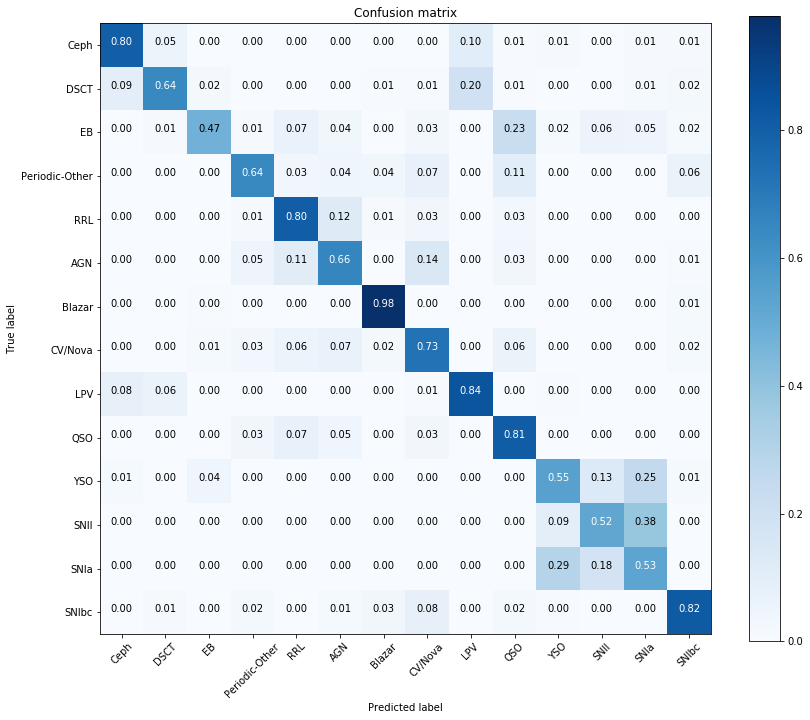

In [21]:
print("Accuracy:", accuracy_score(y_test.classALeRCE, y_name_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test.classALeRCE, y_name_pred))
cm_matrix = confusion_matrix(y_test.classALeRCE, y_name_pred)
plot_confusion_matrix(cm_matrix, classes)

## Kernel Density Estimation 

In [22]:
public_test = pd.read_pickle('public_test_data.pkl')
public_test = public_test.replace([np.inf, -np.inf], np.nan)
public_test = public_test.fillna(-999)
public_test.head()

x_test = public_test.drop(['hierClass', 'classALeRCE', 'challenge_oid', 'outClass', 'outType'], axis=1)
y_test = public_test[['hierClass', 'classALeRCE', 'outClass', 'outType']]

test_hier_proba = hier_clf.predict_proba(x_test)
test_per_proba = clf_periodic.predict_proba(x_test)
test_tr_proba = clf_transcient.predict_proba(x_test)
test_st_proba = clf_stochastic.predict_proba(x_test)

prob_per_mtx = np.repeat(test_hier_proba[:,0], test_per_proba.shape[1]).reshape(test_hier_proba.shape[0], test_per_proba.shape[1])
y_prob_per = test_per_proba * prob_per_mtx

prob_st_mtx = np.repeat(test_hier_proba[:,1], test_st_proba.shape[1]).reshape(test_hier_proba.shape[0], test_st_proba.shape[1])
y_prob_st = test_st_proba * prob_st_mtx

prob_tr_mtx = np.repeat(test_hier_proba[:,2], test_tr_proba.shape[1]).reshape(test_hier_proba.shape[0], test_tr_proba.shape[1])
y_prob_tr = test_tr_proba * prob_tr_mtx

y_probs = np.concatenate((y_prob_per, y_prob_st, y_prob_tr), axis=1)

inlier_test = y_probs[y_test.outClass == 'Inlier']
outlier_ELL = y_probs[y_test.outType == 'ELL']
outlier_EMS = y_probs[y_test.outType == 'EMS']
outlier_IVS = y_probs[y_test.outType == 'IVS']
outlier_SLSN = y_probs[y_test.outType == 'SLSN']


In [23]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(inlier_test)

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [24]:
scores_inliers = kde.score_samples(inlier_test)
scores_ELL = kde.score_samples(outlier_ELL)
scores_EMS = kde.score_samples(outlier_EMS)
scores_IVS = kde.score_samples(outlier_IVS)
scores_SLSN = kde.score_samples(outlier_SLSN)


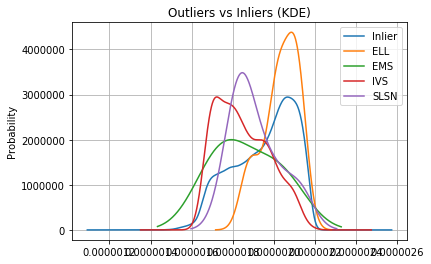

In [25]:
in_ = pd.DataFrame(np.exp(scores_inliers), columns=['Inlier'])
ELL_ = pd.DataFrame(np.exp(scores_ELL), columns=['ELL'])
EMS_ = pd.DataFrame(np.exp(scores_EMS), columns=['EMS'])
IVS_ = pd.DataFrame(np.exp(scores_IVS), columns=['IVS'])
SLSN_ = pd.DataFrame(np.exp(scores_SLSN), columns=['SLSN'])



fig, ax = plt.subplots()
in_.plot.kde(ax=ax, legend=True, title='Outliers vs Inliers (KDE)')
ELL_.plot.kde(ax=ax, legend=True)
EMS_.plot.kde(ax=ax, legend=True)
IVS_.plot.kde(ax=ax, legend=True)
SLSN_.plot.kde(ax=ax, legend=True)

ax.set_ylabel('Probability')
ax.grid(axis='x')
ax.grid(axis='y')

plt.savefig('kde.png')

In [32]:
outlier_test = y_probs[y_test.outClass == 'Outlier']
scores_outlier = kde.score_samples(outlier_test)


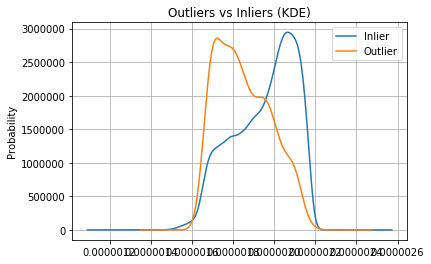

In [33]:
out_ = pd.DataFrame(np.exp(scores_outlier), columns=['Outlier'])


fig, ax = plt.subplots()
in_.plot.kde(ax=ax, legend=True, title='Outliers vs Inliers (KDE)')
out_.plot.kde(ax=ax, legend=True)


ax.set_ylabel('Probability')
ax.grid(axis='x')
ax.grid(axis='y')

plt.savefig('kde_bin.png')